In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# --- Load data -----
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/CAR DETAILS FROM CAR DEKHO.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# - check Data ---
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
print(f"Rows and Columns:{df.shape}")

Rows and Columns:(4340, 8)


In [5]:
# -- check Data  ---
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [6]:
# - - check Data  ---
df.describe()

,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [7]:
# 3. Data Cleaning
# Drop duplicates
df.drop_duplicates(inplace=True)

In [8]:
# Check for nulls
print(df.isnull().sum().any())

False


In [9]:
# --- Feature engineering ------
# Extract brand from name
df['brand'] = df['name'].astype(str).str.split().str[0].fillna('unknown')

In [10]:
# --- Feature engineering ------
from datetime import datetime
CURRENT_YEAR = datetime.now().year
df['car_age'] = CURRENT_YEAR - df['year']
# Drop year column (since we use car_age)
df.drop(columns=['year'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

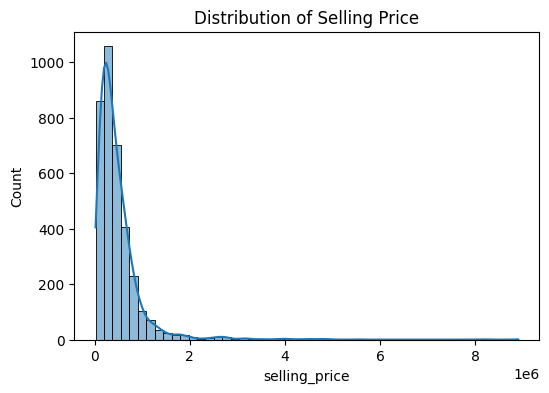

In [11]:
# Exploratory Data Analysis
# ===============================
#Selling Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df['selling_price'], bins=50, kde=True)
plt.title("Distribution of Selling Price")
plt.show()

**Highly right skewed**

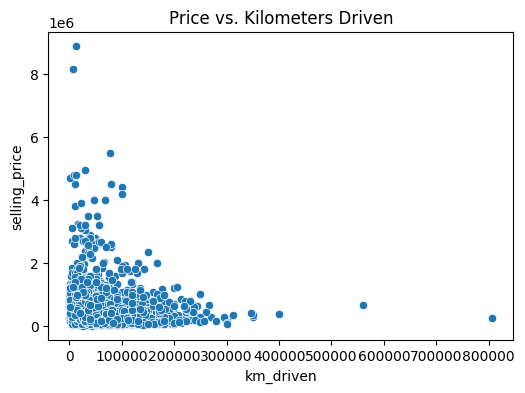

In [12]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='km_driven', y='selling_price', data=df)
plt.title("Price vs. Kilometers Driven")
plt.show()

**Highly right skewed**

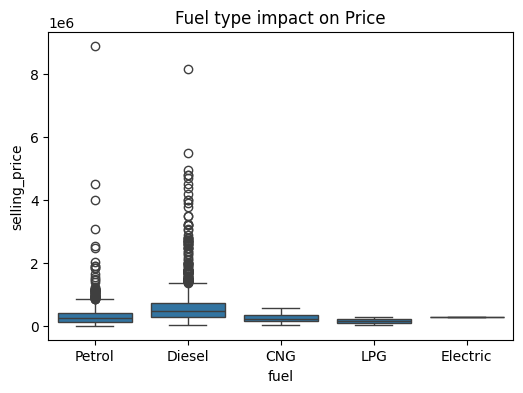

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(x='fuel', y='selling_price', data=df)
plt.title("Fuel type impact on Price")
plt.show()

**Business meaning:**

Some high prices might be luxury cars (BMW, Audi, Mercedes, etc.) which are real values, not errors.

If your goal is to model the typical used car market, these will distort  results (median, regression, etc.).

**Impact on model/statistics:**

For descriptive stats (median, mean, plots), outliers heavily skew results.

For predictive modeling, algorithms like linear regression are sensitive, but tree-based models (Random Forest, XGBoost) are more robust.

**Possible strategies:**
✅ Keep them if you want a complete market analysis (including luxury cars).
✅ Remove or cap them (e.g., 99th percentile cutoff) if you want to focus on the mass market.
✅ Use log-transform on selling_price to reduce skewness without dropping data.
**I will just go as it is.**

In [14]:
# -- Define Features and Target --
# ===============================
X = df.drop(columns=['selling_price', 'name'])  # drop target + name (not useful)
y = df['selling_price']

In [15]:
# Categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

In [16]:
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: Index(['fuel', 'seller_type', 'transmission', 'owner', 'brand'], dtype='object')
Numerical columns: Index(['km_driven', 'car_age'], dtype='object')


In [17]:
# Preprocessor
log1p_transformer = FunctionTransformer(np.log1p, validate=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["car_age"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [18]:
#  Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [19]:
#  Models to Compare
# ===============================
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42)
}

results = {}

In [20]:
# Model Training & Evaluation
# ===============================
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {"R2": r2, "MAE": mae, "RMSE": rmse}

In [21]:
# Convert to DataFrame for comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n")
print(results_df)


Model Comparison:

                         R2            MAE           RMSE
Linear Regression  0.534263  180949.482308  387336.475123
Ridge Regression   0.530040  182177.330330  389088.314519
Lasso Regression   0.532337  181473.403853  388136.375578
Decision Tree      0.403951  175237.588167  438186.510866
Random Forest      0.555101  159369.056277  378572.081580
Gradient Boosting  0.515045  162238.318797  395247.078194
AdaBoost           0.313922  300563.910992  470115.588681


In [22]:
#  Best Model Insights
# ===============================
best_model_name = results_df['R2'].idxmax()
print(f"\n✅ Best Model: {best_model_name}")


✅ Best Model: Random Forest


In [23]:
# Train best model fully
best_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', models[best_model_name])])
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['car_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['fuel', 'seller_type', 'transmission', 'owner', 'brand'], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

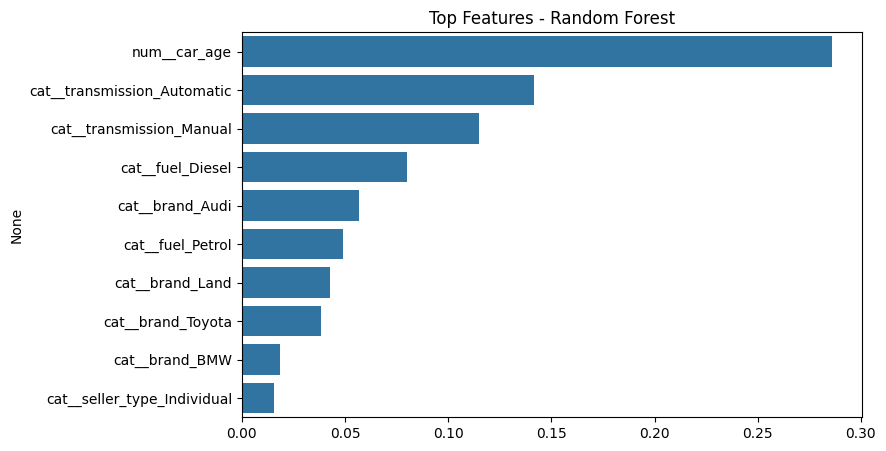

In [27]:
# Feature importance (for tree-based models)
if best_model_name not in ["Linear Regression", "Ridge Regression", "Lasso Regression"]:
    # Get feature names after preprocessing
    feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

    importances = best_model.named_steps['model'].feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"Top Features - {best_model_name}")
    plt.show()

In [28]:
# Hyperparameter Tuning
# ===============================

if best_model_name in ["Random Forest", "Gradient Boosting", "Decision Tree", "AdaBoost", "Linear Regression", "Ridge Regression", "Lasso Regression"]:
    print(f"\n🔍 Hyperparameter Tuning for {best_model_name}...")

    # Define parameter grids for supported models
    param_grids = {
        "Random Forest": {
            'model__n_estimators': [100],
            'model__max_depth': [10,15],
            'model__min_samples_split': [2,3],
            'model__min_samples_leaf': [1, 2]
        },
        "Gradient Boosting": {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.8, 1.0]
        },
        "Decision Tree": {
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        },
        "AdaBoost": {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.05, 0.1, 1.0]
        },
         "Linear Regression": {
            'model__fit_intercept': [True, False],

        },
        "Ridge Regression": {
            'model__alpha': [0.1, 1.0, 10.0],
        },
        "Lasso Regression": {
            'model__alpha': [0.1, 1.0, 10.0],
        }
    }

    # Get the parameter grid for the best model
    param_grid = [param_grids[best_model_name]]


🔍 Hyperparameter Tuning for Random Forest...


In [29]:
# Create pipeline
grid_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', models[best_model_name])])

In [30]:
# GridSearchCV
grid_search = GridSearchCV(
        estimator=grid_pipe,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=2
    )
grid_search.fit(X_train, y_train)

print("\n✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV R² Score:", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

✅ Best Parameters: {'model__max_depth': 15, 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 100}
✅ Best CV R² Score: 0.6506535446609094


In [31]:
 # Evaluate on test set
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test)

tuned_r2 = r2_score(y_test, y_pred_tuned)
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print("\n📊 Tuned Model Performance on Test Set:")
print("R²:", tuned_r2)
print("MAE:", tuned_mae)
print("RMSE:", tuned_rmse)


📊 Tuned Model Performance on Test Set:
R²: 0.5646423496301013
MAE: 157519.33645984292
RMSE: 374490.61446201825


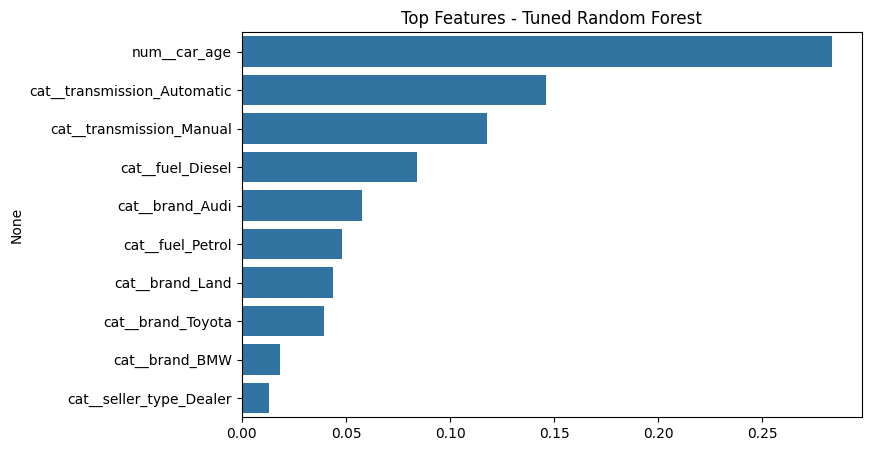

In [33]:
# Feature importance again
if best_model_name not in ["Linear Regression", "Ridge Regression", "Lasso Regression"]:
    # Get feature names from preprocessed training data
    preprocessed_X_train = tuned_model.named_steps['preprocessor'].transform(X_train)
    # If the output is a sparse matrix, convert to dense and get column names
    if isinstance(preprocessed_X_train, np.ndarray):
        feature_names = tuned_model.named_steps['preprocessor'].get_feature_names_out()
    else: # Assuming sparse matrix
        feature_names = tuned_model.named_steps['preprocessor'].get_feature_names_out()


    importances = tuned_model.named_steps['model'].feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"Top Features - Tuned {best_model_name}")
    plt.show()

In [34]:
# Save the Final Model
# ===============================
import pickle

# Save tuned model if available, else best_model
final_model = tuned_model if 'tuned_model' in locals() else best_model

with open("used_car_price_model.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("✅ Model saved as used_car_price_model.pkl")


✅ Model saved as used_car_price_model.pkl


In [35]:
#  Load the Model (Example)
# ===============================
with open("used_car_price_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# Test with sample data
sample = X_test.iloc[0:1]   # take first row from test set
pred_price = loaded_model.predict(sample)
print("\n🚗 Predicted Price for used Car:", round(pred_price[0],3))


🚗 Predicted Price for used Car: 480354.128
